# Lab 2 Presentation - Data Visualization for Linear Modeling

Erez Buchweitz

We have data, and suppose we want to fit ordinary least squared (OLS):
$$
\hat{\boldsymbol{\beta}}= (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{Y},
$$ in order to minimize the average squared error loss
$\mathscr{L}(y, \hat{y}) = (y- \hat{y})^2$ on a test set.

In [110]:
import numpy as np

n = 10000
x1 = np.random.uniform(size=n)
x2 = np.random.normal(size=n)
eps = np.random.normal(scale=2, size=n)
y = 3 * x1 ** 2 + x2 / 3 + eps

# First attempt to plot

Let us explore the relation between `x1` and `y` using a scatter plot.

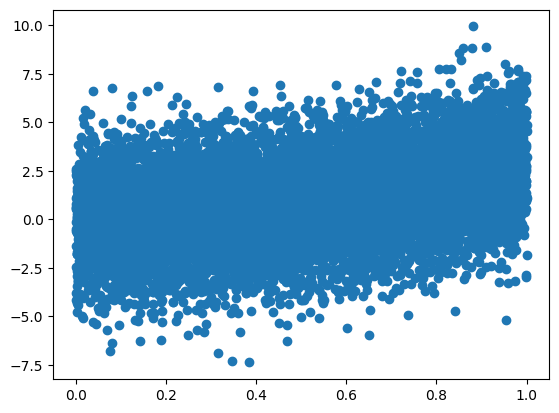

In [111]:
from matplotlib import pyplot as plt

plt.scatter(x1, y)

There seems to be some kind of upward trend, but the data are very
noisy. What can we do?

# Introducing `quantile_plot`

This functions bins the `x` values into `bins` bins, and plot the mean
`y` value for each bin.

In [112]:
import numpy as np
from matplotlib import pyplot as plt

def quantile_plot(x, y, by=None, bins=10, by_bins=3, y_fn=np.mean):
    assert len(x) == len(y)

    def qp_data(x, y):
        fac = np.searchsorted(np.quantile(x, q=[i / bins for i in range(1, bins)]), x)
        ufac = np.unique(fac)
        qx = np.array([np.mean(x[fac == f]) for f in ufac])
        qy = np.array([y_fn(y[fac == f]) for f in ufac])
        return qx, qy

    qx, qy = qp_data(x, y)
    if by is None:
        plt.plot(qx, qy, "-o")
    else:
        assert len(x) == len(by)
        plt.plot(qx, qy, "-o", label="ALL", color="lightgrey")
        by_fac = np.searchsorted(np.quantile(by, q=[i / by_bins for i in range(1, by_bins)]), by)
        by_ufac = np.unique(by_fac)
        for i, f in enumerate(np.unique(by_ufac)):
            mask = by_fac == f
            nm = f"{i}) {min(by[mask]):.2f} / {max(by[mask]):.2f}"
            qx, qy = qp_data(x[mask], y[mask])
            plt.plot(qx, qy, "-o", label=nm)
        plt.legend()

Let us run `quantile_plot` on `x1` and `y`.

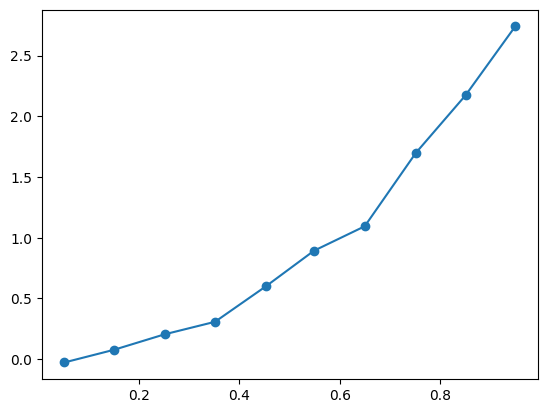

In [113]:
quantile_plot(x1, y, bins=10)

The plot now is much less noisy, and the upward trend is very clear.

# Is this a good fit for a linear model?

Is it linear? Let us add a line that represents the OLS prediction.

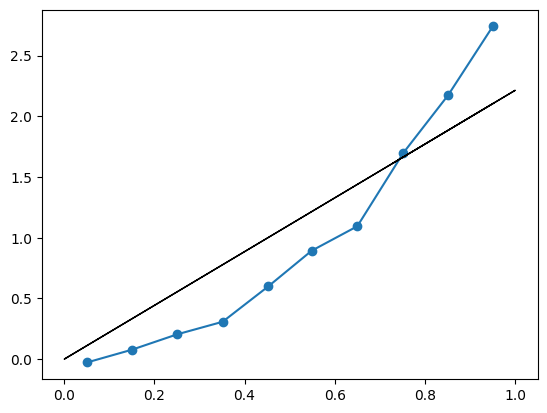

In [114]:
quantile_plot(x1, y)
b1 = sum(x1 * y) / sum(x1 ** 2)
plt.plot(x1, x1 * b1, color='black', linewidth=1)

The black (OLS) is not a good fit. Should we care?

Recall from class, we showed that the minimizer of squared error is the
conditional mean: $$
f^* = \arg\min\left\{\mathbb{E}_{\vphantom{}}\left[(y-f(\boldsymbol{x}))^2\right]: f \text{ function}\right\} \; \; \; \; \text{if and only if} \; \; \; \; f^*(\boldsymbol{x})=\mathbb{E}_{\vphantom{}}\left[y|\boldsymbol{x}\right].
$$ The blue line is relatively smooth, to the extent that we may believe
that the true mean of `y` as function of `x_1` follows closely to it.
Therefore, the best possible prediction if we want to minimize squared
error would be roughly the blue line.

So, yes, we should care. If we run OLS on `x1` we will predict the black
line, which is quite far from optimal.

How can we improve the prediction?

# Feature engineering

Let us try a quadratic relation, $y=x_1^2$. We create a new variable
`x1_sq` which is the square of `x1`, and repeat the process over `x1_sq`
and `y` instead.

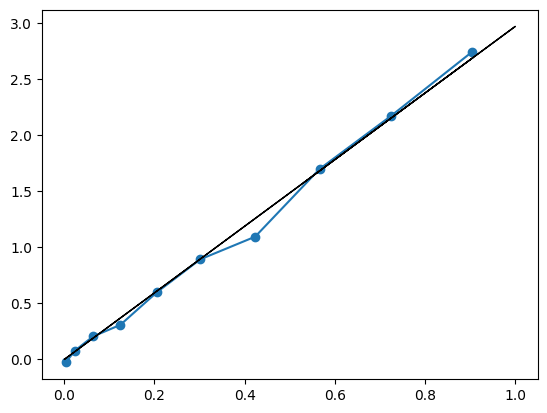

In [115]:
x1_sq = x1 ** 2
quantile_plot(x1_sq, y, bins=10)
b1_sq = sum(x1_sq * y) / sum(x1_sq ** 2)
plt.plot(x1_sq, x1_sq * b1_sq, color='black', linewidth=1)

The black (OLS) line looks like a good fit now. The deviations of the
blue line are small and seemingly random. Or are they?

In any case, OLS in `x1_sq` looks like a better fit that OLS in `x1`. We
seem to be predicting close to the true conditional mean: $$
\mathbb{E}_{\vphantom{}}\left[y|x_1\right] \approx \beta  x_1^2.
$$

Will this translate to reduced squared error? Let us check.

In [116]:
def squared_error(y, yhat):
    return np.mean((y - yhat) ** 2)

squared_error(y, np.mean(y)), squared_error(y, x1 * b1), squared_error(y, x1_sq * b1_sq)

(4.903522114285841, 4.218220045517391, 4.087226795661047)

On the left is the variance of $y$, which is the squared error if we
predict the empirical average of $y$. In the middle is the squared error
for the linear model in $x_1$. On the right is the squared error for the
linear model in $x_1^2$.

We see that the model with $x_1^2$ is indeed better than the model in
$x_1$, but not by that much. This is probably as much as we can get from
this feature alone.

# Interaction

Let us try one more thing. We add to the mix another feature $x_2$, and
plot the joint contribution of $x_1^2$ and $x_2$ to $y$. `quantile_plot`
allows that by binning the `by` variable (in this case `x2`) into
`by_bins` bins, and plots multiple `quantile_plot`, one for each level
of the `by` variable.

In the case below, the blue line corresponds to `quantile_plot` between
`x1_sq` and `y` for data with low `x2`. The orange line corresponds to
medium-range `x2`, and the green line to high values of `x2`.

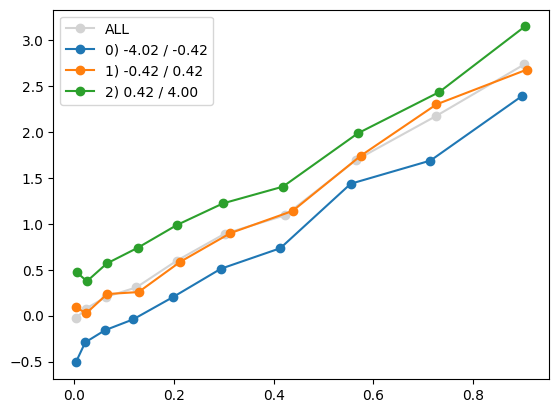

In [117]:
quantile_plot(x1_sq, y, bins=10, by=x2, by_bins=3)

We see that the three lines are relatively parallel, which means there
is probably no interaction between `x1_sq` and `x2`. The fact that the
green line lies above the orange line, which lies above the blue line,
indicates a main effect for `x2`. The fact that each of the lines is
increasing indicates a main effect for `x1_sq`.

Taken together, we should probably include both `x1_sq` and `x2` in our
model, as two separate features.